In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id, deepcopy_ast
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

2023-06-27 11:17:16 - ast_utils - DEBUG    - Using cache folder: /tmp/game_generation_cache
2023-06-27 11:17:16 - src.ast_utils - DEBUG    - Using cache folder: /tmp/game_generation_cache
2023-06-27 11:17:16 - wandb.docker.auth - DEBUG    - Trying paths: ['/Users/guydavidson/.docker/config.json', '/Users/guydavidson/.dockercfg']
2023-06-27 11:17:16 - wandb.docker.auth - DEBUG    - Found file at path: /Users/guydavidson/.docker/config.json
2023-06-27 11:17:16 - wandb.docker.auth - DEBUG    - Found 'credsStore' section


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.981622,0.982730,0.972647,0.982941,0.983447,0.985028,0.922134,0.917226,0.975440,0.987710
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.949317,0.942306,0.969335,0.980352,0.979375,0.985628,0.924614,0.933171,0.947230,0.963873
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.978548,0.982250,0.000000,0.000000,0.000000,0.000000,0.848037,0.861549,0.925661,0.945054
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.988626,0.988172,0.000000,0.000000,0.000000,0.000000,0.922134,0.917226,0.975440,0.987710
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.984418,0.982744,0.000000,0.000000,0.000000,0.000000,0.979648,0.978512,0.971713,0.987759


In [5]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [6]:
HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS = dict(hspace=0.3)


def plot_value_histograms(results_by_feature_name_and_value: typing.Dict[str, typing.Dict[int, typing.List[float]]],
    bins: int = 20, histogram_log_y: bool = False, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    k = len(results_by_feature_name_and_value.keys())

    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, feature_name in enumerate(results_by_feature_name_and_value.keys()):
        if layout[0] == 1:
            ax = axes[i]
        else:
            ax = axes[i // layout[1]][i % layout[1]]

        values_with = results_by_feature_name_and_value[feature_name][1]
        values_without = results_by_feature_name_and_value[feature_name][0]

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([values_with, values_without], label=[f'1 (n={len(values_with)})', f'0 (n={len(values_without)})'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Fitness value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title = f'#{i + 1}: {feature_name}'
        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()


def analyze_archive_fullness(model: MAPElitesSampler, mutually_exclusive_features: typing.Optional[typing.List[str]] = None,
                             plot_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    if plot_kwargs is None:
        plot_kwargs = {}
    
    results_by_feature_name = {feature_name: defaultdict(list) for feature_name in model.map_elites_feature_names}
    results_by_feature_count = defaultdict(list)

    for key, fitness_value in model.fitness_values.items():
        for feature_name, feature_value in model._key_to_feature_dict(key).items():
            results_by_feature_name[feature_name][feature_value].append(fitness_value)

        if isinstance(key, int):
            key_bits = count_set_bits(key)
        else:
            key_bits = sum(k != 0 for k in key)

        results_by_feature_count[key_bits].append(fitness_value)

    display(Markdown(f'## Archive fullness analysis'))
    display(Markdown(f'Ttoal of {len(model.fitness_values)} samples in archive, {len(model.map_elites_feature_names)} features'))
    display(Markdown(f'### Results by feature'))
    lines = []
    for feature_name, results in results_by_feature_name.items():
        lines.append(f'- {feature_name}:')
        for feature_value in sorted(results.keys()):
            value_results = results[feature_value]
            lines.append(f'    - ={feature_value}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)})')

    display(Markdown('\n'.join(lines)))

    display(Markdown(f'### Results by set feature count'))
    lines = []
    for feature_count in sorted(results_by_feature_count.keys()):
        value_results = results_by_feature_count[feature_count]
        lines.append(f'- set-count={feature_count}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)} / {math.comb(len(model.map_elites_feature_names), feature_count)})')

    display(Markdown('\n'.join(lines)))

    plot_value_histograms(results_by_feature_name, **plot_kwargs)


In [7]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']

def plot_sampler_fitness_trajectory(
        evo: PopulationBasedSampler, title: typing.Optional[str] = None, 
        axsize: typing.Tuple[int, int] = (8, 6),
        plot_metrics: typing.Optional[bool] = None, 
        ignore_metrics: typing.Optional[typing.List[str]] = DEFAULT_IGNORE_METRICS,
        subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
        min_real_game_fitness: float = 57.9193, max_real_game_fitness: float = 62.9249): 

    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0  # type: ignore

    if ignore_metrics is None:
        ignore_metrics = []
            
    layout = (1, 2) if plot_metrics else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys() if key not in ignore_metrics}  # type: ignore
        for step_dict in evo.archive_metrics_history:  # type: ignore
            for key, value in step_dict.items():
                if key in metrics:
                    metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key)

        metrics_ax.set_xlabel('Generation')
        metrics_ax.set_ylabel('Metric Value')

        metrics_ax.legend(loc='best')

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

In [8]:
# fitness_rank_node_count_objects = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_fitness_rank_node_count_objects_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_node_count_objects, 'MAP-Elites, Node Count, Unique Objects, & Setup Features, Fitness Rank')

# fitness_rank_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_fitness_rank_node_count_predicates_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_node_count_predicates, 'MAP-Elites, Node Count, Unique Predicates, & Setup Features, Fitness Rank')

# ucb_node_count_objects = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_ucb_node_count_objects_setup_final'))
# plot_sampler_fitness_trajectory(ucb_node_count_objects, 'MAP-Elites, Node Count, Unique Objects, & Setup Features, UCB')

# ucb_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_13', 'samples', 'evo_sampler_map_elites_ucb_node_count_predicates_setup_final'))
# plot_sampler_fitness_trajectory(ucb_node_count_predicates, 'MAP-Elites, Node Count, Unique Predicates, & Setup Features, UCB')


In [9]:
# fitness_rank_object_categories = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_categories_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories, 'MAP-Elites, Object Categories & Setup Exists Features, Fitness Rank')

# fitness_rank_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_final'))
# plot_sampler_fitness_trajectory(fitness_rank_predicates, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank')

# fitness_rank_object_categories_crossover = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_categories_setup_crossover_final'))
# plot_sampler_fitness_trajectory(fitness_rank_object_categories_crossover, 'MAP-Elites, Object Categories & Setup Exists Features, Fitness Rank, With Crossover')

# fitness_rank_predicates_crossover = typing.cast(MAPElitesSampler, utils.load_data('2023_05_15', 'samples', 'map_elites_fitness_rank_specific_predicates_setup_crossover_final'))
# plot_sampler_fitness_trajectory(fitness_rank_predicates_crossover, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, With Crossover')

In [10]:
# specific_predicates_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_specific_predicates_setup_final'))
# plot_sampler_fitness_trajectory(specific_predicates_setup, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

# specific_categories_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_specific_categories_setup_final'))
# plot_sampler_fitness_trajectory(specific_categories_setup, 'MAP-Elites, Categories & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

# node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19_1', 'samples', 'map_elites_msgpack_spawn_node_count_specific_predicates_final'))
# plot_sampler_fitness_trajectory(node_count_predicates, 'MAP-Elites, Node Count & Features, Fitness Rank, Crossover & Cognitive Ops')

# pca_features_0_3 = typing.cast(MAPElitesSampler, utils.load_data('2023_06_19', 'samples', 'map_elites_fitness_rank_pca_features_0-3_gen_512'))
# plot_sampler_fitness_trajectory(pca_features_0_3, 'MAP-Elites, PCA Features 0-3, 512 steps, Fitness Rank, Crossover & Cognitive Ops')

# pca_features_2_5 = typing.cast(MAPElitesSampler, utils.load_data('2023_06_20', 'samples', 'map_elites_fitness_rank_pca_features_2-5_gen_512'))
# plot_sampler_fitness_trajectory(pca_features_2_5, 'MAP-Elites, PCA Features 2-5, 512 steps, Fitness Rank, Crossover & Cognitive Ops')

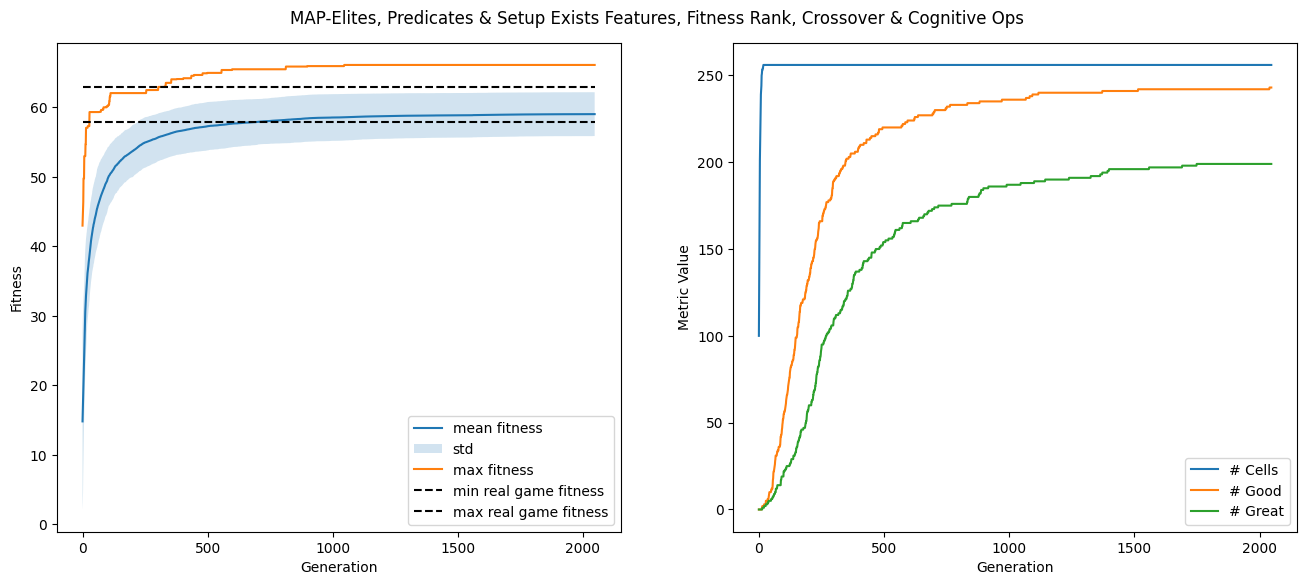

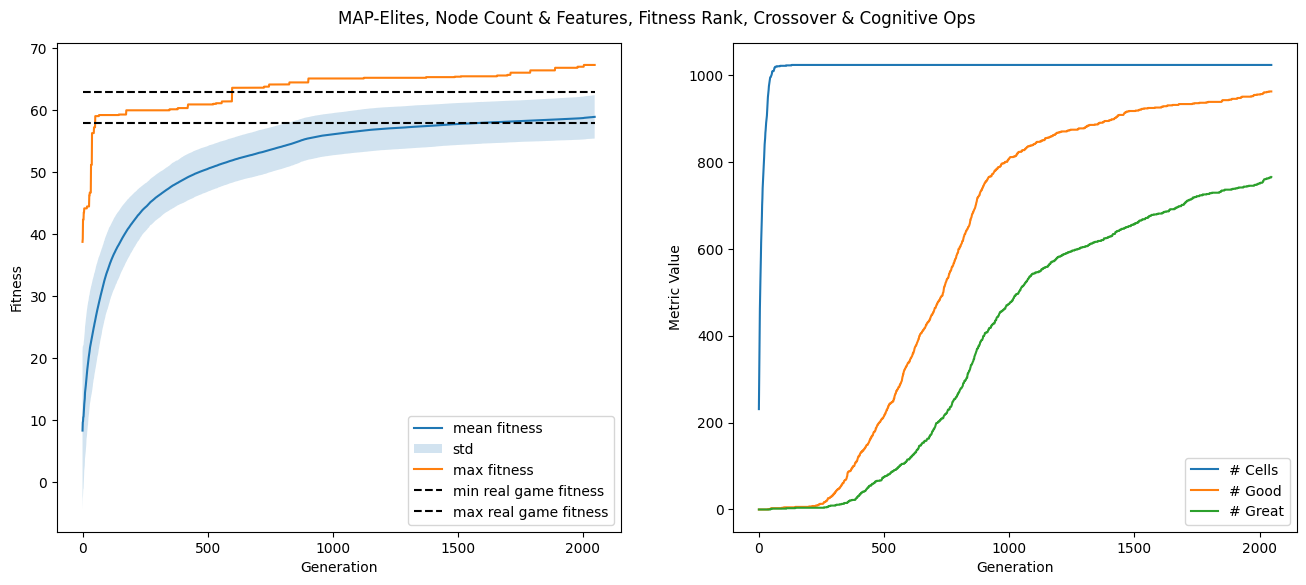

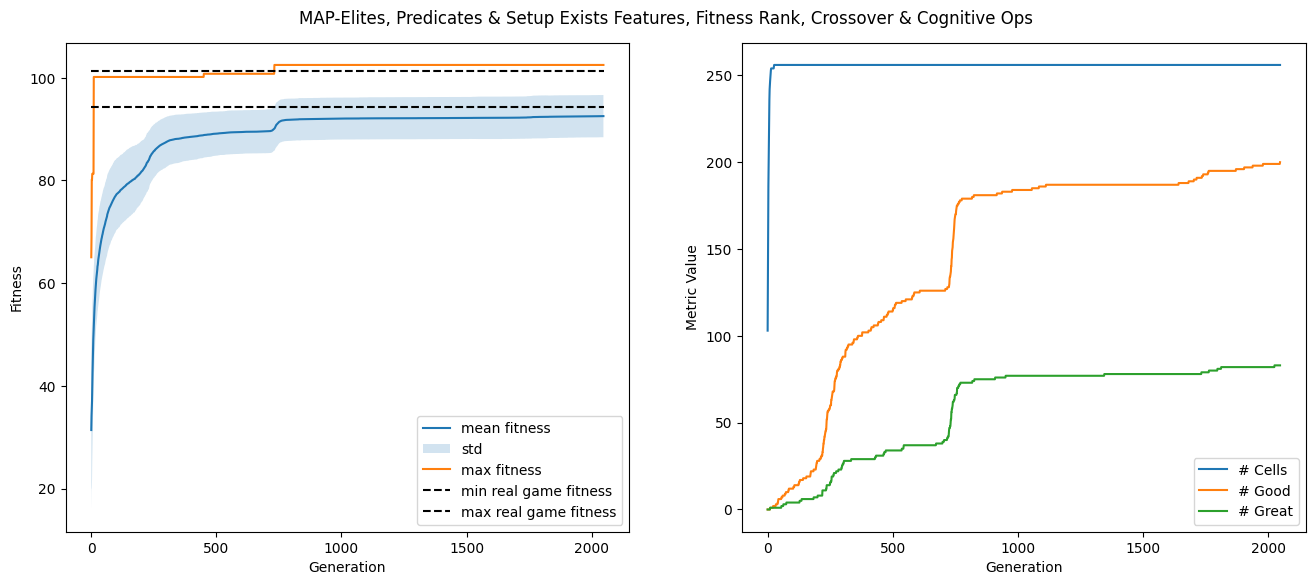

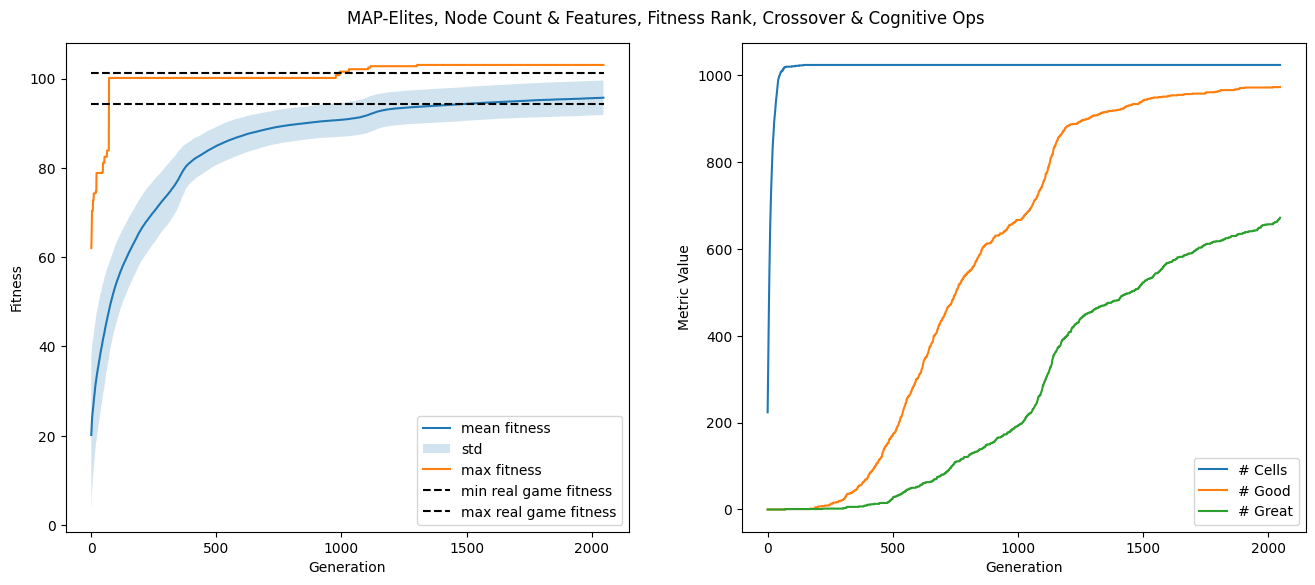

In [11]:
specific_predicates_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_23', 'samples', 'map_elites_specific_predicates_setup_final'))
plot_sampler_fitness_trajectory(specific_predicates_setup, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops')

node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_06_23', 'samples', 'map_elites_node_count_specific_predicates_final'))
plot_sampler_fitness_trajectory(node_count_predicates, 'MAP-Elites, Node Count & Features, Fitness Rank, Crossover & Cognitive Ops')

specific_objects_ngram_specific_predicates_setup = typing.cast(MAPElitesSampler, utils.load_data('2023_06_23', 'samples', 'map_elites_specific_objects_ngram_specific_predicates_setup_final'))

plot_sampler_fitness_trajectory(specific_objects_ngram_specific_predicates_setup, 'MAP-Elites, Predicates & Setup Exists Features, Fitness Rank, Crossover & Cognitive Ops',
                                min_real_game_fitness=94.2391, max_real_game_fitness=101.3713)

specific_objects_ngram_node_count_predicates = typing.cast(MAPElitesSampler, utils.load_data('2023_06_23', 'samples', 'map_elites_specific_objects_ngram_node_count_specific_predicates_final'))
plot_sampler_fitness_trajectory(specific_objects_ngram_node_count_predicates, 'MAP-Elites, Node Count & Features, Fitness Rank, Crossover & Cognitive Ops',
                                min_real_game_fitness=94.2391, max_real_game_fitness=101.3713)




In [14]:
tolerance = 1e-1

model = node_count_predicates
count = 0
max_diff = -np.inf

computed_values = []

for key, sample in model.population.items():
    recorded_fitness = model.fitness_values[key]
    computed_fitness = model._score_proposal(sample)
    if not np.isclose(recorded_fitness, computed_fitness, atol=tolerance):
        computed_values.append(computed_fitness)
        diff = np.abs(recorded_fitness - computed_fitness)
        print(key, recorded_fitness, computed_fitness)
        if diff > max_diff:
            max_diff = diff
        count += 1


print(f'A total of {count} recorded fitness values were not equal to the computed fitness values, with a max difference of {max_diff:.4f}')

(7, 1, 1, 1, 0, 1, 0, 1) 62.226654052734375 52.74308776855469
(7, 0, 1, 1, 0, 1, 1, 0) 63.90449142456055 50.69655990600586
(7, 0, 1, 1, 0, 1, 0, 0) 63.69777297973633 51.224727630615234
(7, 1, 0, 1, 0, 0, 1, 0) 61.33023452758789 40.76498794555664
(7, 0, 0, 1, 1, 0, 0, 0) 61.78212356567383 42.61954879760742
(7, 0, 1, 1, 0, 0, 1, 0) 63.10871887207031 51.79130172729492
(7, 0, 1, 1, 0, 0, 1, 1) 62.934722900390625 52.26325225830078
(7, 0, 1, 1, 0, 0, 0, 0) 61.273136138916016 49.547481536865234
(7, 1, 0, 1, 1, 1, 0, 0) 63.49765396118164 39.99653625488281
(7, 1, 0, 1, 1, 1, 1, 0) 64.28749084472656 39.81621551513672
(7, 1, 0, 1, 1, 0, 1, 0) 63.0225944519043 46.1395149230957
(7, 1, 0, 1, 0, 1, 1, 0) 65.70654296875 48.050174713134766
(7, 1, 0, 1, 0, 0, 0, 0) 66.07669067382812 47.18082046508789
(7, 0, 0, 1, 0, 0, 0, 1) 57.67092514038086 39.11296844482422
(7, 1, 0, 0, 0, 1, 0, 1) 61.17569351196289 37.69416046142578
(7, 0, 0, 1, 0, 1, 1, 0) 61.66850280761719 40.63118362426758
(7, 1, 0, 1, 0, 1, 1, 1

In [13]:
key = (7, 1, 1, 1, 0, 1, 0, 1)
sample = model.population[key]
sample_features = model._proposal_to_features(sample)
sample_features
# sample_tensor = model._features_to_tensor(sample_features)
# print(sample_tensor.sum(), sample_tensor.norm())

# sample_fitness = model._evaluate_fitness(sample_tensor)
# print(sample_fitness)

{'src_file': '',
 'game_name': 'evo-1470-96-1',
 'domain_name': 'few-objects-room-v1',
 'real': False,
 'variables_defined_all': 1,
 'variables_defined_incorrect_count': 0.0,
 'variables_used_all': 1,
 'variables_used_incorrect_count': 0.0,
 'preferences_used_all': 1,
 'preferences_used_incorrect_count': 0.0,
 'num_preferences_defined_1': False,
 'num_preferences_defined_2': True,
 'num_preferences_defined_3': False,
 'num_preferences_defined_4': False,
 'num_preferences_defined_5': False,
 'num_preferences_defined_6': False,
 'setup_objects_used': 0.0,
 'setup_quantified_objects_used': 0.0,
 'adjacent_once_found': 0,
 'no_adjacent_same_modal': 1,
 'starts_and_ends_once': 0.0,
 'once_in_middle_of_pref_found': 0,
 'pref_without_hold_found': 0,
 'length_of_then_modals_1': 0,
 'length_of_then_modals_2': 0,
 'length_of_then_modals_3': 0,
 'length_of_then_modals_4': 1,
 'length_of_then_modals_5': 0,
 'length_of_then_modals_6': 0,
 'length_of_then_modals_7': 0,
 'at_end_found': 1,
 'max_quan

In [17]:
import pickle
sample_features_str = b'\x80\x04\x95\xc0@\x00\x00\x00\x00\x00\x00}\x94(\x8c\x08src_file\x94\x8c\x00\x94\x8c\tgame_name\x94\x8c\revo-1470-96-1\x94\x8c\x0bdomain_name\x94\x8c\x13few-objects-room-v1\x94\x8c\x04real\x94\x89\x8c\x15variables_defined_all\x94K\x01\x8c!variables_defined_incorrect_count\x94\x8c\x15numpy.core.multiarray\x94\x8c\x06scalar\x94\x93\x94\x8c\x05numpy\x94\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94bC\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x12variables_used_all\x94K\x01\x8c\x1evariables_used_incorrect_count\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x14preferences_used_all\x94K\x01\x8c preferences_used_incorrect_count\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x19num_preferences_defined_1\x94h\x0ch\x0f\x8c\x02b1\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01|\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94bC\x01\x00\x94\x86\x94R\x94\x8c\x19num_preferences_defined_2\x94h\x0ch%C\x01\x01\x94\x86\x94R\x94\x8c\x19num_preferences_defined_3\x94h*\x8c\x19num_preferences_defined_4\x94h*\x8c\x19num_preferences_defined_5\x94h*\x8c\x19num_preferences_defined_6\x94h*\x8c\x12setup_objects_used\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x1dsetup_quantified_objects_used\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x13adjacent_once_found\x94K\x00\x8c\x16no_adjacent_same_modal\x94K\x01\x8c\x14starts_and_ends_once\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x1conce_in_middle_of_pref_found\x94K\x00\x8c\x17pref_without_hold_found\x94K\x00\x8c\x17length_of_then_modals_1\x94K\x00\x8c\x17length_of_then_modals_2\x94K\x00\x8c\x17length_of_then_modals_3\x94K\x00\x8c\x17length_of_then_modals_4\x94K\x01\x8c\x17length_of_then_modals_5\x94K\x00\x8c\x17length_of_then_modals_6\x94K\x00\x8c\x17length_of_then_modals_7\x94K\x00\x8c\x0cat_end_found\x94K\x01\x8c max_quantification_count_setup_0\x94K\x00\x8c max_quantification_count_setup_1\x94K\x01\x8c max_quantification_count_setup_2\x94K\x00\x8c max_quantification_count_setup_3\x94K\x00\x8c max_quantification_count_setup_4\x94K\x00\x8c max_quantification_count_setup_5\x94K\x00\x8c&max_quantification_count_constraints_0\x94K\x00\x8c&max_quantification_count_constraints_1\x94K\x01\x8c&max_quantification_count_constraints_2\x94K\x00\x8c&max_quantification_count_constraints_3\x94K\x00\x8c&max_quantification_count_constraints_4\x94K\x00\x8c&max_quantification_count_constraints_5\x94K\x00\x8c-max_number_variables_types_quantified_types_1\x94K\x00\x8c-max_number_variables_types_quantified_types_2\x94K\x00\x8c-max_number_variables_types_quantified_types_3\x94K\x01\x8c-max_number_variables_types_quantified_types_4\x94K\x00\x8c-max_number_variables_types_quantified_types_5\x94K\x00\x8c-max_number_variables_types_quantified_types_6\x94K\x00\x8c-max_number_variables_types_quantified_types_7\x94K\x00\x8c-max_number_variables_types_quantified_types_8\x94K\x00\x8c1max_number_variables_types_quantified_variables_1\x94K\x01\x8c1max_number_variables_types_quantified_variables_2\x94K\x00\x8c1max_number_variables_types_quantified_variables_3\x94K\x00\x8c1max_number_variables_types_quantified_variables_4\x94K\x00\x8c1max_number_variables_types_quantified_variables_5\x94K\x00\x8c1max_number_variables_types_quantified_variables_6\x94K\x00\x8c1max_number_variables_types_quantified_variables_7\x94K\x00\x8c1max_number_variables_types_quantified_variables_8\x94K\x00\x8c\x18repeated_variables_found\x94K\x00\x8c\x15nested_logicals_found\x94K\x00\x8c identical_logical_children_found\x94K\x00\x8c identical_scoring_children_found\x94K\x00\x8c(scoring_count_expression_repetitions_max\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\xf0?\x94\x86\x94R\x94\x8c\x1dtautological_expression_found\x94K\x00\x8c\x1aredundant_expression_found\x94K\x00\x8c+redundant_scoring_terminal_expression_found\x94K\x00\x8c/identical_consecutive_seq_func_predicates_found\x94K\x00\x8c\x18disjoint_seq_funcs_found\x94K\x00\x8c8pref_forall_count_once_per_external_objects_used_correct\x94K\x00\x8c:pref_forall_count_once_per_external_objects_used_incorrect\x94K\x00\x8c@pref_forall_count_once_per_external_objects_used_incorrect_count\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c(pref_forall_external_forall_used_correct\x94K\x00\x8c*pref_forall_external_forall_used_incorrect\x94K\x00\x8c0pref_forall_external_forall_used_incorrect_count\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x18pref_forall_used_correct\x94K\x00\x8c\x1apref_forall_used_incorrect\x94K\x00\x8c pref_forall_used_incorrect_count\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c-pref_forall_pref_forall_correct_arity_correct\x94K\x00\x8c/pref_forall_pref_forall_correct_arity_incorrect\x94K\x00\x8c5pref_forall_pref_forall_correct_arity_incorrect_count\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c-pref_forall_pref_forall_correct_types_correct\x94K\x00\x8c/pref_forall_pref_forall_correct_types_incorrect\x94K\x00\x8c5pref_forall_pref_forall_correct_types_incorrect_count\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x1atwo_number_operation_found\x94K\x00\x8c%single_argument_multi_operation_found\x94K\x00\x8c,section_without_pref_or_total_count_terminal\x94K\x00\x8c+section_without_pref_or_total_count_scoring\x94K\x00\x8c$predicate_under_modal_at_end_between\x94K\x01\x8c%predicate_under_modal_at_end_distance\x94K\x00\x8c/predicate_under_modal_at_end_object_orientation\x94K\x00\x8c"predicate_under_modal_at_end_touch\x94K\x00\x8c%predicate_under_modal_at_end_adjacent\x94K\x00\x8c\x1fpredicate_under_modal_at_end_in\x94K\x00\x8c(predicate_under_modal_at_end_agent_holds\x94K\x00\x8c&predicate_under_modal_at_end_in_motion\x94K\x00\x8c\x1fpredicate_under_modal_at_end_on\x94K\x00\x8c,predicate_under_modal_at_end_adjacent_side_3\x94K\x00\x8c"predicate_under_modal_once_between\x94K\x00\x8c#predicate_under_modal_once_distance\x94K\x00\x8c-predicate_under_modal_once_object_orientation\x94K\x00\x8c predicate_under_modal_once_touch\x94K\x00\x8c#predicate_under_modal_once_adjacent\x94K\x00\x8c\x1dpredicate_under_modal_once_in\x94K\x00\x8c&predicate_under_modal_once_agent_holds\x94K\x01\x8c$predicate_under_modal_once_in_motion\x94K\x00\x8c\x1dpredicate_under_modal_once_on\x94K\x00\x8c*predicate_under_modal_once_adjacent_side_3\x94K\x00\x8c*predicate_under_modal_once_measure_between\x94K\x00\x8c+predicate_under_modal_once_measure_distance\x94K\x00\x8c5predicate_under_modal_once_measure_object_orientation\x94K\x00\x8c(predicate_under_modal_once_measure_touch\x94K\x00\x8c+predicate_under_modal_once_measure_adjacent\x94K\x00\x8c%predicate_under_modal_once_measure_in\x94K\x00\x8c.predicate_under_modal_once_measure_agent_holds\x94K\x00\x8c,predicate_under_modal_once_measure_in_motion\x94K\x00\x8c%predicate_under_modal_once_measure_on\x94K\x00\x8c2predicate_under_modal_once_measure_adjacent_side_3\x94K\x00\x8c(predicate_under_modal_while_hold_between\x94K\x00\x8c)predicate_under_modal_while_hold_distance\x94K\x00\x8c3predicate_under_modal_while_hold_object_orientation\x94K\x00\x8c&predicate_under_modal_while_hold_touch\x94K\x01\x8c)predicate_under_modal_while_hold_adjacent\x94K\x00\x8c#predicate_under_modal_while_hold_in\x94K\x00\x8c,predicate_under_modal_while_hold_agent_holds\x94K\x01\x8c*predicate_under_modal_while_hold_in_motion\x94K\x00\x8c#predicate_under_modal_while_hold_on\x94K\x00\x8c0predicate_under_modal_while_hold_adjacent_side_3\x94K\x00\x8c"predicate_under_modal_hold_between\x94K\x00\x8c#predicate_under_modal_hold_distance\x94K\x00\x8c-predicate_under_modal_hold_object_orientation\x94K\x00\x8c predicate_under_modal_hold_touch\x94K\x00\x8c#predicate_under_modal_hold_adjacent\x94K\x00\x8c\x1dpredicate_under_modal_hold_in\x94K\x00\x8c&predicate_under_modal_hold_agent_holds\x94K\x01\x8c$predicate_under_modal_hold_in_motion\x94K\x01\x8c\x1dpredicate_under_modal_hold_on\x94K\x00\x8c*predicate_under_modal_hold_adjacent_side_3\x94K\x00\x8c0adjacent_arg_types_furniture_large_objects_setup\x94K\x01\x8c(agent_holds_arg_types_blocks_constraints\x94K\x01\x8c&in_motion_arg_types_blocks_constraints\x94K\x01\x8c=object_orientation_arg_types_large_objects_orientations_setup\x94K\x01\x8c(touch_arg_types_agent_blocks_constraints\x94K\x01\x8c\x1ccompositionality_structure_0\x94K\x01\x8c\x1ccompositionality_structure_1\x94K\x00\x8c\x1ccompositionality_structure_2\x94K\x01\x8c\x1ccompositionality_structure_3\x94K\x00\x8c\x1ccompositionality_structure_4\x94K\x00\x8c\x1ccompositionality_structure_5\x94K\x00\x8c\x1ccompositionality_structure_6\x94K\x00\x8c\x1ccompositionality_structure_7\x94K\x00\x8c\x1ccompositionality_structure_8\x94K\x00\x8c\x1ccompositionality_structure_9\x94K\x00\x8c\x11max_depth_setup_0\x94K\x00\x8c\x11max_depth_setup_1\x94K\x01\x8c\x11max_depth_setup_2\x94K\x00\x8c\x11max_depth_setup_3\x94K\x00\x8c\x11max_depth_setup_4\x94K\x00\x8c\x17max_depth_constraints_0\x94K\x00\x8c\x17max_depth_constraints_1\x94K\x01\x8c\x17max_depth_constraints_2\x94K\x00\x8c\x17max_depth_constraints_3\x94K\x00\x8c\x17max_depth_constraints_4\x94K\x00\x8c\x14max_depth_terminal_0\x94K\x01\x8c\x14max_depth_terminal_1\x94K\x00\x8c\x14max_depth_terminal_2\x94K\x00\x8c\x14max_depth_terminal_3\x94K\x00\x8c\x14max_depth_terminal_4\x94K\x00\x8c\x13max_depth_scoring_0\x94K\x00\x8c\x13max_depth_scoring_1\x94K\x00\x8c\x13max_depth_scoring_2\x94K\x00\x8c\x13max_depth_scoring_3\x94K\x00\x8c\x13max_depth_scoring_4\x94K\x01\x8c\x12mean_depth_setup_0\x94K\x00\x8c\x12mean_depth_setup_1\x94K\x00\x8c\x12mean_depth_setup_2\x94K\x01\x8c\x12mean_depth_setup_3\x94K\x00\x8c\x12mean_depth_setup_4\x94K\x00\x8c\x18mean_depth_constraints_0\x94K\x00\x8c\x18mean_depth_constraints_1\x94K\x01\x8c\x18mean_depth_constraints_2\x94K\x00\x8c\x18mean_depth_constraints_3\x94K\x00\x8c\x18mean_depth_constraints_4\x94K\x00\x8c\x15mean_depth_terminal_0\x94K\x01\x8c\x15mean_depth_terminal_1\x94K\x00\x8c\x15mean_depth_terminal_2\x94K\x00\x8c\x15mean_depth_terminal_3\x94K\x00\x8c\x15mean_depth_terminal_4\x94K\x00\x8c\x14mean_depth_scoring_0\x94K\x00\x8c\x14mean_depth_scoring_1\x94K\x00\x8c\x14mean_depth_scoring_2\x94K\x00\x8c\x14mean_depth_scoring_3\x94K\x00\x8c\x14mean_depth_scoring_4\x94K\x01\x8c\x12node_count_setup_0\x94K\x00\x8c\x12node_count_setup_1\x94K\x00\x8c\x12node_count_setup_2\x94K\x01\x8c\x12node_count_setup_3\x94K\x00\x8c\x12node_count_setup_4\x94K\x00\x8c\x18node_count_constraints_0\x94K\x00\x8c\x18node_count_constraints_1\x94K\x00\x8c\x18node_count_constraints_2\x94K\x01\x8c\x18node_count_constraints_3\x94K\x00\x8c\x18node_count_constraints_4\x94K\x00\x8c\x15node_count_terminal_0\x94K\x01\x8c\x15node_count_terminal_1\x94K\x00\x8c\x15node_count_terminal_2\x94K\x00\x8c\x15node_count_terminal_3\x94K\x00\x8c\x15node_count_terminal_4\x94K\x00\x8c\x14node_count_scoring_0\x94K\x00\x8c\x14node_count_scoring_1\x94K\x00\x8c\x14node_count_scoring_2\x94K\x00\x8c\x14node_count_scoring_3\x94K\x00\x8c\x14node_count_scoring_4\x94K\x01\x8c\x11max_width_setup_0\x94K\x00\x8c\x11max_width_setup_1\x94K\x00\x8c\x11max_width_setup_2\x94K\x01\x8c\x11max_width_setup_3\x94K\x00\x8c\x11max_width_setup_4\x94K\x00\x8c\x17max_width_constraints_0\x94K\x00\x8c\x17max_width_constraints_1\x94K\x00\x8c\x17max_width_constraints_2\x94K\x01\x8c\x17max_width_constraints_3\x94K\x00\x8c\x17max_width_constraints_4\x94K\x00\x8c\x14max_width_terminal_0\x94K\x01\x8c\x14max_width_terminal_1\x94K\x00\x8c\x14max_width_terminal_2\x94K\x00\x8c\x14max_width_terminal_3\x94K\x00\x8c\x14max_width_terminal_4\x94K\x00\x8c\x13max_width_scoring_0\x94K\x00\x8c\x13max_width_scoring_1\x94K\x00\x8c\x13max_width_scoring_2\x94K\x01\x8c\x13max_width_scoring_3\x94K\x00\x8c\x13max_width_scoring_4\x94K\x00\x8c\x1asection_doesnt_exist_setup\x94\x89\x8c\x1dsection_doesnt_exist_terminal\x94\x88\x8c\x18ast_ngram_full_n_2_score\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\xf0?\x94\x86\x94R\x94\x8c\x18ast_ngram_full_n_3_score\x94h\x0ch\x12C\x08\x9dc\xd6\x04\x01\x0b\xee?\x94\x86\x94R\x94\x8c\x18ast_ngram_full_n_4_score\x94h\x0ch\x12C\x08\xb1/\x10w6\xa4\xec?\x94\x86\x94R\x94\x8c\x18ast_ngram_full_n_5_score\x94h\x0ch\x12C\x08\xaa\xa8\x1dX\x89\x1e\xeb?\x94\x86\x94R\x94\x8c\x18ast_ngram_full_n_6_score\x94h\x0ch\x12C\x08\xb8\xdf["5\xb5\xea?\x94\x86\x94R\x94\x8c\x18ast_ngram_full_n_7_score\x94h\x0ch\x12C\x08~\xedh@\x13\xeb\xe9?\x94\x86\x94R\x94\x8c\x19ast_ngram_setup_n_2_score\x94h\x0ch\x12C\x08\x9ar\xea\x15\xe6\x19\xec?\x94\x86\x94R\x94\x8c\x19ast_ngram_setup_n_3_score\x94h\x0ch\x12C\x08Y@\xca;\x82\xfc\xec?\x94\x86\x94R\x94\x8c\x19ast_ngram_setup_n_4_score\x94h\x0ch\x12C\x08\xa2\x1a\x92\xd8m\xd9\xeb?\x94\x86\x94R\x94\x8c\x19ast_ngram_setup_n_5_score\x94h\x0ch\x12C\x08e\xb2\x15\xad\xc13\xea?\x94\x86\x94R\x94\x8c\x1fast_ngram_constraints_n_2_score\x94h\x0ch\x12C\x08{\xe3\xcf\x17\x98/\xe6?\x94\x86\x94R\x94\x8c\x1fast_ngram_constraints_n_3_score\x94h\x0ch\x12C\x08f\x03\x91\xb8\xef\x9c\xe6?\x94\x86\x94R\x94\x8c\x1fast_ngram_constraints_n_4_score\x94h\x0ch\x12C\x08\xf7n\x93\xfbj\x84\xe6?\x94\x86\x94R\x94\x8c\x1fast_ngram_constraints_n_5_score\x94h\x0ch\x12C\x08\xf1\xa4\xa3\r\xd7m\xe6?\x94\x86\x94R\x94\x8c\x1fast_ngram_constraints_n_6_score\x94h\x0ch\x12C\x08\x8b\'IG\x84\xc6\xe5?\x94\x86\x94R\x94\x8c\x1fast_ngram_constraints_n_7_score\x94h\x0ch\x12C\x08\x8c;\x1ba\xd4\x0c\xe5?\x94\x86\x94R\x94\x8c\x1cast_ngram_terminal_n_2_score\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x1cast_ngram_terminal_n_3_score\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x1cast_ngram_terminal_n_4_score\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x1cast_ngram_terminal_n_5_score\x94h\x0ch\x12C\x08\x00\x00\x00\x00\x00\x00\x00\x00\x94\x86\x94R\x94\x8c\x1bast_ngram_scoring_n_2_score\x94h\x0ch\x12C\x08\xeay\x9f\xd5 [\xef?\x94\x86\x94R\x94\x8c\x1bast_ngram_scoring_n_3_score\x94h\x0ch\x12C\x08\x0b\x8ah\xc6\x11m\xee?\x94\x86\x94R\x94\x8c\x1bast_ngram_scoring_n_4_score\x94h\x0ch\x12C\x08G\xb9\xc7i\x07\xb6\xed?\x94\x86\x94R\x94\x8c\x1bast_ngram_scoring_n_5_score\x94h\x0ch\x12C\x08>B\xa1{\xf6\xac\xec?\x94\x86\x94R\x94\x8c\x1eadjacent_arg_types_other_setup\x94K\x00\x8c(adjacent_arg_types_balls_furniture_setup\x94K\x00\x8c)adjacent_arg_types_blocks_furniture_setup\x94K\x00\x8c-adjacent_arg_types_blocks_room_features_setup\x94K\x00\x8c.adjacent_arg_types_furniture_receptacles_setup\x94K\x00\x8c2adjacent_arg_types_receptacles_room_features_setup\x94K\x00\x8c*adjacent_arg_types_agent_balls_constraints\x94K\x00\x8c$adjacent_arg_types_other_constraints\x94K\x00\x8c+adjacent_arg_types_agent_blocks_constraints\x94K\x00\x8c.adjacent_arg_types_agent_furniture_constraints\x94K\x00\x8c2adjacent_arg_types_agent_large_objects_constraints\x94K\x00\x8c*adjacent_arg_types_agent_ramps_constraints\x94K\x00\x8c0adjacent_arg_types_agent_receptacles_constraints\x94K\x00\x8c2adjacent_arg_types_agent_room_features_constraints\x94K\x00\x8c4adjacent_arg_types_any_object_any_object_constraints\x94K\x00\x8c6adjacent_arg_types_furniture_large_objects_constraints\x94K\x00\x8c8adjacent_arg_types_receptacles_room_features_constraints\x94K\x00\x8c:adjacent_arg_types_room_features_room_features_constraints\x94K\x00\x8c=adjacent_side_3_arg_types_furniture_sides_large_objects_setup\x94K\x00\x8c%adjacent_side_3_arg_types_other_setup\x94K\x00\x8c8adjacent_side_3_arg_types_receptacles_sides_blocks_setup\x94K\x00\x8c+adjacent_side_3_arg_types_other_constraints\x94K\x00\x8c!agent_holds_arg_types_other_setup\x94K\x00\x8c\'agent_holds_arg_types_other_constraints\x94K\x00\x8c\'agent_holds_arg_types_agent_constraints\x94K\x00\x8c,agent_holds_arg_types_any_object_constraints\x94K\x00\x8c\'agent_holds_arg_types_balls_constraints\x94K\x00\x8c+agent_holds_arg_types_furniture_constraints\x94K\x00\x8c/agent_holds_arg_types_large_objects_constraints\x94K\x00\x8c-agent_holds_arg_types_receptacles_constraints\x94K\x00\x8c/agent_holds_arg_types_room_features_constraints\x94K\x00\x8c/agent_holds_arg_types_small_objects_constraints\x94K\x00\x8c\x1dbetween_arg_types_other_setup\x94K\x00\x8c#between_arg_types_other_constraints\x94K\x01\x8c\x1edistance_arg_types_other_setup\x94K\x00\x8c$distance_arg_types_balls_balls_setup\x94K\x00\x8c(distance_arg_types_balls_furniture_setup\x94K\x00\x8c*distance_arg_types_balls_receptacles_setup\x94K\x00\x8c,distance_arg_types_balls_room_features_setup\x94K\x00\x8c&distance_arg_types_blocks_blocks_setup\x94K\x00\x8c)distance_arg_types_blocks_furniture_setup\x94K\x00\x8c+distance_arg_types_blocks_receptacles_setup\x94K\x00\x8c-distance_arg_types_blocks_room_features_setup\x94K\x00\x8c.distance_arg_types_furniture_receptacles_setup\x94K\x00\x8c4distance_arg_types_large_objects_room_features_setup\x94K\x00\x8c*distance_arg_types_ramps_receptacles_setup\x94K\x00\x8c,distance_arg_types_ramps_room_features_setup\x94K\x00\x8c2distance_arg_types_receptacles_room_features_setup\x94K\x00\x8c*distance_arg_types_agent_balls_constraints\x94K\x00\x8c.distance_arg_types_agent_furniture_constraints\x94K\x00\x8c$distance_arg_types_other_constraints\x94K\x00\x8c0distance_arg_types_agent_receptacles_constraints\x94K\x00\x8c2distance_arg_types_agent_room_features_constraints\x94K\x00\x8c7distance_arg_types_any_object_room_features_constraints\x94K\x00\x8c+distance_arg_types_balls_blocks_constraints\x94K\x00\x8c,distance_arg_types_blocks_blocks_constraints\x94K\x00\x8c/distance_arg_types_blocks_furniture_constraints\x94K\x00\x8c1distance_arg_types_blocks_receptacles_constraints\x94K\x00\x8c.distance_arg_types_furniture_ramps_constraints\x94K\x00\x8c:distance_arg_types_large_objects_room_features_constraints\x94K\x00\x8c\x18in_arg_types_other_setup\x94K\x00\x8c"in_arg_types_building_blocks_setup\x94K\x00\x8c\x1ein_arg_types_other_constraints\x94K\x00\x8c.in_arg_types_any_object_any_object_constraints\x94K\x00\x8c$in_arg_types_balls_balls_constraints\x94K\x00\x8c,in_arg_types_building_any_object_constraints\x94K\x00\x8c(in_arg_types_building_blocks_constraints\x94K\x00\x8c-in_arg_types_building_receptacles_constraints\x94K\x00\x8c\x1fin_motion_arg_types_other_setup\x94K\x00\x8c0in_arg_types_furniture_small_objects_constraints\x94K\x00\x8c%in_motion_arg_types_other_constraints\x94K\x00\x8c/in_arg_types_receptacles_any_object_constraints\x94K\x00\x8c*in_arg_types_receptacles_balls_constraints\x94K\x00\x8c+in_arg_types_receptacles_blocks_constraints\x94K\x00\x8c-in_arg_types_receptacles_building_constraints\x94K\x00\x8c2in_arg_types_receptacles_large_objects_constraints\x94K\x00\x8c0in_arg_types_receptacles_receptacles_constraints\x94K\x00\x8c2in_arg_types_receptacles_small_objects_constraints\x94K\x00\x8c%in_motion_arg_types_agent_constraints\x94K\x00\x8c*in_motion_arg_types_any_object_constraints\x94K\x00\x8c%in_motion_arg_types_balls_constraints\x94K\x00\x8c)in_motion_arg_types_furniture_constraints\x94K\x00\x8c-in_motion_arg_types_large_objects_constraints\x94K\x00\x8c+in_motion_arg_types_receptacles_constraints\x94K\x00\x8c-in_motion_arg_types_room_features_constraints\x94K\x00\x8c-in_motion_arg_types_small_objects_constraints\x94K\x00\x8c(object_orientation_arg_types_other_setup\x94K\x00\x8c;object_orientation_arg_types_receptacles_orientations_setup\x94K\x00\x8c.object_orientation_arg_types_other_constraints\x94K\x00\x8cCobject_orientation_arg_types_large_objects_orientations_constraints\x94K\x00\x8cAobject_orientation_arg_types_receptacles_orientations_constraints\x94K\x00\x8c\x18on_arg_types_other_setup\x94K\x00\x8c on_arg_types_blocks_blocks_setup\x94K\x00\x8c\'on_arg_types_furniture_any_object_setup\x94K\x00\x8c"on_arg_types_furniture_balls_setup\x94K\x00\x8c#on_arg_types_furniture_blocks_setup\x94K\x00\x8c*on_arg_types_furniture_large_objects_setup\x94K\x00\x8c(on_arg_types_furniture_receptacles_setup\x94K\x00\x8c.on_arg_types_large_objects_large_objects_setup\x94K\x00\x8c$on_arg_types_receptacles_balls_setup\x94K\x00\x8c&on_arg_types_room_features_balls_setup\x94K\x00\x8c\'on_arg_types_room_features_blocks_setup\x94K\x00\x8c\x1eon_arg_types_other_constraints\x94K\x00\x8c.on_arg_types_any_object_any_object_constraints\x94K\x00\x8c$on_arg_types_balls_balls_constraints\x94K\x00\x8c%on_arg_types_blocks_balls_constraints\x94K\x00\x8c&on_arg_types_blocks_blocks_constraints\x94K\x00\x8c-on_arg_types_furniture_any_object_constraints\x94K\x00\x8c(on_arg_types_furniture_balls_constraints\x94K\x00\x8c0on_arg_types_furniture_large_objects_constraints\x94K\x00\x8c.on_arg_types_furniture_receptacles_constraints\x94K\x00\x8c0on_arg_types_furniture_small_objects_constraints\x94K\x00\x8c,on_arg_types_large_objects_balls_constraints\x94K\x00\x8c4on_arg_types_large_objects_large_objects_constraints\x94K\x00\x8c2on_arg_types_large_objects_receptacles_constraints\x94K\x00\x8c$on_arg_types_ramps_balls_constraints\x94K\x00\x8c*on_arg_types_receptacles_agent_constraints\x94K\x00\x8c*on_arg_types_receptacles_balls_constraints\x94K\x00\x8c2on_arg_types_receptacles_large_objects_constraints\x94K\x00\x8c0on_arg_types_receptacles_receptacles_constraints\x94K\x00\x8c,on_arg_types_room_features_agent_constraints\x94K\x00\x8c,on_arg_types_room_features_balls_constraints\x94K\x00\x8c-on_arg_types_room_features_blocks_constraints\x94K\x00\x8c4on_arg_types_room_features_large_objects_constraints\x94K\x00\x8c2on_arg_types_room_features_receptacles_constraints\x94K\x00\x8c4on_arg_types_room_features_small_objects_constraints\x94K\x00\x8c\x1btouch_arg_types_other_setup\x94K\x00\x8c\'touch_arg_types_agent_balls_constraints\x94K\x00\x8c!touch_arg_types_other_constraints\x94K\x00\x8c-touch_arg_types_agent_receptacles_constraints\x94K\x00\x8c,touch_arg_types_any_object_balls_constraints\x94K\x00\x8c-touch_arg_types_any_object_blocks_constraints\x94K\x00\x8c\'touch_arg_types_balls_balls_constraints\x94K\x00\x8c(touch_arg_types_balls_blocks_constraints\x94K\x00\x8c+touch_arg_types_balls_furniture_constraints\x94K\x00\x8c/touch_arg_types_balls_large_objects_constraints\x94K\x00\x8c\'touch_arg_types_balls_ramps_constraints\x94K\x00\x8c-touch_arg_types_balls_receptacles_constraints\x94K\x00\x8c/touch_arg_types_balls_room_features_constraints\x94K\x00\x8c)touch_arg_types_blocks_blocks_constraints\x94K\x00u.'

alt_sample_features = pickle.loads(sample_features_str)


In [18]:
alt_sample_features.keys()

dict_keys(['src_file', 'game_name', 'domain_name', 'real', 'variables_defined_all', 'variables_defined_incorrect_count', 'variables_used_all', 'variables_used_incorrect_count', 'preferences_used_all', 'preferences_used_incorrect_count', 'num_preferences_defined_1', 'num_preferences_defined_2', 'num_preferences_defined_3', 'num_preferences_defined_4', 'num_preferences_defined_5', 'num_preferences_defined_6', 'setup_objects_used', 'setup_quantified_objects_used', 'adjacent_once_found', 'no_adjacent_same_modal', 'starts_and_ends_once', 'once_in_middle_of_pref_found', 'pref_without_hold_found', 'length_of_then_modals_1', 'length_of_then_modals_2', 'length_of_then_modals_3', 'length_of_then_modals_4', 'length_of_then_modals_5', 'length_of_then_modals_6', 'length_of_then_modals_7', 'at_end_found', 'max_quantification_count_setup_0', 'max_quantification_count_setup_1', 'max_quantification_count_setup_2', 'max_quantification_count_setup_3', 'max_quantification_count_setup_4', 'max_quantificati

In [ ]:
for key in sample_features:
    if key in alt_sample_features:
        if sample_features[key] != alt_sample_features[key]:
            print(key, sample_features[key], alt_sample_features[key], sample_features[key] - alt_sample_features[key])
    else:
        print(key, 'not in alt_sample_features')

In [ ]:
bigrams = model.fitness_featurizer.header_registry['ast_ngram'].n_gram_model.ngram_ast_parser.parse_test_input(sample, n_values=[2])[1]['(:constraints'][2]
server_bigrams = [('<start>', 'constraints'),
 ('constraints', 'preferences'),
 ('preferences', 'preference'),
 ('preference', 'pref_body_exists'),
 ('pref_body_exists', 'either_types'),
 ('either_types', 'blocks'),
 ('blocks', 'large_objects'),
 ('large_objects', 'small_objects'),
 ('small_objects', 'receptacles'),
 ('receptacles', 'at_end'),
 ('at_end', 'predicate_between'),
 ('predicate_between', 'furniture'),
 ('furniture', 'receptacles'),
 ('receptacles', 'either_types_blocks_large_objects_small_objects'),
 ('either_types_blocks_large_objects_small_objects', 'preference'),
 ('preference', 'pref_body_exists'),
 ('pref_body_exists', 'blocks'),
 ('blocks', 'then'),
 ('then', 'once'),
 ('once', 'predicate_agent_holds'),
 ('predicate_agent_holds', 'blocks'),
 ('blocks', 'hold'),
 ('hold', 'super_predicate_and'),
 ('super_predicate_and', 'predicate_in_motion'),
 ('predicate_in_motion', 'blocks'),
 ('blocks', 'super_predicate_not'),
 ('super_predicate_not', 'predicate_agent_holds'),
 ('predicate_agent_holds', 'blocks'),
 ('blocks', 'while_hold'),
 ('while_hold', 'super_predicate_and'),
 ('super_predicate_and', 'super_predicate_not'),
 ('super_predicate_not', 'predicate_agent_holds'),
 ('predicate_agent_holds', 'blocks'),
 ('blocks', 'predicate_touch'),
 ('predicate_touch', 'agent'),
 ('agent', 'blocks'),
 ('blocks', 'hold'),
 ('hold', 'predicate_agent_holds'),
 ('predicate_agent_holds', 'blocks'),
 ('blocks', '<end>')]

for i in range(len(bigrams)):
    if bigrams[i] != server_bigrams[i]:
        print(i, bigrams[i], server_bigrams[i])

In [ ]:
print(ast_printer.ast_to_string(sample, '\n'))

In [ ]:
# model = specific_predicates_setup
# index = 1
# key = model.top_sample_key(index)
# sample = model.population[key]  # type: ignore


# # print(ast_str)
# # grammar_parser.parse(ast_str)

# game_fitness, game_features = model._score_proposal(sample, return_features=True)
# print(game_fitness)

# sample_copy = deepcopy_ast(sample)
# sample_copy = list(sample_copy)
# for i in range(len(sample_copy)):
#     if isinstance(sample_copy[i], tuple) and sample_copy[i][0] in (ast_parser.SETUP, ast_parser.TERMINAL) and len(sample_copy[i]) < 3:
#         sample_copy[i] = (*sample_copy[i], ')')
# sample_copy = tuple(sample_copy)

# copied_fitness, copied_features = model._score_proposal(sample_copy, return_features=True)
# print(copied_fitness)

# sample_copy_str = ast_printer.ast_to_string(sample_copy, '\n')
# reparsed_sample = grammar_parser.parse(sample_copy_str)
# reparsed_fitness, reparsed_features = model._score_proposal(reparsed_sample, return_features=True)
# print(reparsed_fitness)

# # {key: value for key, value in sample_features.items() if 'once' in key}
# for key in game_features:
#     if game_features[key] != reparsed_features[key]:
#         print(key, game_features[key], reparsed_features[key])


In [ ]:
# specific_predicates_setup.fitness_featurizer.preprocessors[0].scale_series_min_max_values

In [ ]:
specific_objects_ngram_node_count_predicates.fitness_function_model_name, specific_objects_ngram_node_count_predicates.fitness_function_date_id

In [ ]:
# model = evo_sampler_map_elites_fitness_rank_no_at_end
model = specific_objects_ngram_node_count_predicates
index = 1
n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

key = model.visualize_top_sample(index, feature_keywords_to_print=feature_keywords_to_print, n_features_on=n_features_on, 
    postprocess_sample=True, features=key_features)
sample = model.population[key] 
# print_nearest_real_games(sample, n_similar_real_games_to_print)

In [ ]:
edited_game_str = """
(define (game evo-732-311-0) (:domain medium-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - (either dodgeball) ?v1 - hexagonal_bin)
        (then
          (once (and (agent_holds ?v0) (adjacent desk agent) ) )
          (hold (and (not (agent_holds ?v0) ) (in_motion ?v0) ) )
          (once (and (not (in_motion ?v0) ) (in ?v1 ?v0) ) )
        )
      )
    )
  )
)
(:scoring
  (count preference0)
)
)
"""

game_fitness, game_features = model._score_proposal(sample, return_features=True)
game_features_tensor = model._features_to_tensor(game_features)

edited_game = grammar_parser.parse(edited_game_str)
edited_game_fitness, edited_game_features = model._score_proposal(edited_game, return_features=True)
edited_game_features_tensor = model._features_to_tensor(edited_game_features)
print(edited_game_fitness)

for key in game_features:
    if edited_game_features[key] != game_features[key]:
        print(key, game_features[key], edited_game_features[key])



utils.evaluate_comparison_energy_contributions(
    game_features_tensor, edited_game_features_tensor,
    ast_printer.ast_to_string(sample, '\n'), edited_game_str,
    model.fitness_function, model.feature_names,
)

In [ ]:
model = fitness_rank_predicates

def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(ast, map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(model, game_asts)
high_quality_sample_keys = set([k for k, v in model.fitness_values.items() if v > 70])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


high_quality_no_real_game_keys = [t[0] for t in sorted([(k, model.fitness_values[k]) for k in high_quality_sample_keys if k not in real_game_keys], key=lambda x: x[1], reverse=True)]

In [ ]:
index = 6
key = high_quality_no_real_game_keys[index]
n_features_on = None
feature_keywords_to_print = ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3 
key_features = dict(section_doesnt_exist_setup=0)

key = model._visualize_sample_by_key(key, feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
print_nearest_real_games(model.population[key], n_similar_real_games_to_print)

In [ ]:
def count_set_bits(n): 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in current_uniform.fitness_values.items():
    key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
threshold = 70

def count_set_bits(n):
 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in evo_sampler_map_elites_ucb.fitness_values.items():
    if fitness > threshold:
        key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
from src.evolutionary_sampler_behavioral_features import build_behavioral_features_featurizer, BASIC_BINNED, BASIC_WITH_NODE_DEPTH


featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(current_thompson.population[current_thompson.top_sample_key(i)], 'interactive-beta.pddl', return_row=False) for i in range(1, 51)]
d_generated = featurizer.to_df()
d_generated.describe()

In [ ]:
featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
d_real = featurizer.to_df()

In [ ]:
%matplotlib widget


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
generated_values = d_generated[featurizer.headers[4:-1]].values.T.astype(float)
real_values = d_real[featurizer.headers[4:-1]].values.T.astype(float)
generated_values += np.random.normal(0, 0.1, size=generated_values.shape)
real_values += np.random.normal(0, 0.1, size=real_values.shape)
ax.scatter(*real_values, s=10)
ax.scatter(*generated_values, s=10)
ax.set_xlabel('Node count')
ax.set_ylabel('# Objects')
ax.set_zlabel('# Predicates')

plt.show()

In [ ]:
fitness_df.groupby('real')[[c for c in fitness_df.columns if 'length_of_then' in c]].mean()